**Dataset**
labeled datasset collected from twitter (Lab 1 - Hate Speech.tsv)

**Objective**
classify tweets containing hate speech from other tweets. <br>
0 -> no hate speech <br>
1 -> contains hate speech <br>

**Total Estimated Time = 90-120 Mins**

**Evaluation metric**
macro f1 score

### Import used libraries

In [15]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import nltk

from nltk.stem import WordNetLemmatizer
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer, f1_score

In [16]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ITI\AppData\Roaming\nltk_data...


True

### Load Dataset

###### Note: search how to load the data from tsv file

In [17]:
df=pd.read_csv('Hate_Speech.tsv',sep='\t')

In [18]:
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


### Data splitting

It is a good practice to split the data before EDA helps maintain the integrity of the machine learning process, prevents data leakage, simulates real-world scenarios more accurately, and ensures reliable model performance evaluation on unseen data.

In [19]:
df.drop('id',axis=1,inplace=True)

In [20]:
X = df['tweet']
y = df['label']

In [21]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [22]:
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(25228,) (6307,) (25228,) (6307,)


In [23]:
x_train.head()

17097    big shout out to @user who replaced my hard us...
8390     #happy #monday! no #need or #reason to #feel  ...
12840    check out all the stars who made our sister te...
25608    awesome -- it's the rare wildly hyped phenomen...
9295     jamming to the new @user song my day is made! ...
Name: tweet, dtype: object

### EDA on training data

- check NaNs

In [24]:
x_train.isna().sum()

0

NO missing values 

- check duplicates

In [25]:
x_train.duplicated().sum()

1780

- show a representative sample of data texts to find out required preprocessing steps

In [21]:
sample_size = 5 
sample_texts = x_train['tweet'].sample(sample_size, random_state=1234).tolist()

In [22]:
for idx, text in enumerate(sample_texts):
    print(f"Sample {idx + 1}:")
    print(text)
    print("\n")

Sample 1:
@user corrieeeeeee time!!!!!ð   @user


Sample 2:
cross country season staing soon.... lol not ready for itððð.   #outofshape


Sample 3:
looks like it's going to be a dry paly cloudy june day for our first garden pavilion #wedding âï¸ð¤ congratulations amanda &amp; duncan


Sample 4:
getting out of his sandy grave ð  ð ð #beach #summer #ocean   #beachlife @ carlsbad, california 


Sample 5:
@user better get your @user fix before heading to #brunsco!   face




- check dataset balancing

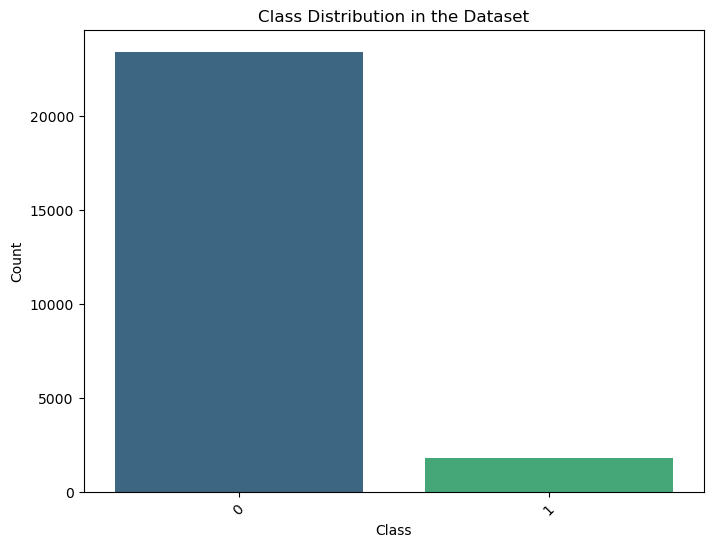

In [23]:
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train, data=x_train, palette='viridis')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution in the Dataset')
plt.xticks(rotation=45)
plt.show()


data is not balaced 

- Cleaning and Preprocessing are:
    - 1 Remove Special Characters and Punctuation
    - 2 Handle Mentions and URLs 
    - 3 Normalize Text
    - 4 Remove Stopwords
    - 5 Handling Emoji and Non-ASCII Characters
    - 6 Lemmatization


### Cleaning and Preprocessing

#### Extra: use custom scikit-learn Transformers

Using custom transformers in scikit-learn provides flexibility, reusability, and control over the data transformation process, allowing you to seamlessly integrate with scikit-learn's pipelines, enabling you to combine multiple preprocessing steps and modeling into a single workflow. This makes your code more modular, readable, and easier to maintain.

##### link: https://www.andrewvillazon.com/custom-scikit-learn-transformers/

#### Example usage:

In [33]:
from sklearn.base import BaseEstimator, TransformerMixin

class TextPreprocessor(BaseEstimator, TransformerMixin):
    def _init_(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        transformed_X = X.copy()
        
#         transformed_X['tweet'] = transformed_X['tweet'].apply(self._preprocess_text)
        transformed_X = transformed_X.apply(self.preprocess_text)
        
        return transformed_X
    
    def fit_transform(self, X, y=None):
        # This function combines fit and transform
        self.fit(X, y)
        return self.transform(X)
    
    def preprocess_text(self,text):
        text = re.sub(r'@([A-Za-z0-9_]+)',' ', text)
        text = re.sub(r'http\S+|www\S+',' ', text)
        
        text = re.sub(r'[^A-Za-z\s]', ' ', text)
        text = re.sub(r'[^A-Za-z0-9\s]', ' ', text)
        text = re.sub(r'[#&]', ' ', text)
        
        text = str(text).lower()
        
        text = text.strip()
        return text

In [34]:
x_train.head()

17097    big shout out to @user who replaced my hard us...
8390     #happy #monday! no #need or #reason to #feel  ...
12840    check out all the stars who made our sister te...
25608    awesome -- it's the rare wildly hyped phenomen...
9295     jamming to the new @user song my day is made! ...
Name: tweet, dtype: object

In [35]:
print(x_train.shape)
text_preprocessor = TextPreprocessor()
preprocessed_data = text_preprocessor.transform(x_train)




(25228,)


In [36]:
preprocessed_data.head()

17097    big shout out to   who replaced my hard used j...
8390     happy  monday  no  need or  reason to  feel   ...
12840     check out all the stars who made our sister team
25608    awesome    it s the rare wildly hyped phenomen...
9295     jamming to the new   song my day is made   hcr...
Name: tweet, dtype: object

**You  are doing Great so far!**

### Modelling

#### Extra: use scikit-learn pipline

##### link: https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

Using pipelines in scikit-learn promotes better code organization, reproducibility, and efficiency in machine learning workflows.

#### Example usage:

### Logistic Regression

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessing', TextPreprocessor()),
    ('Vectorizing', CountVectorizer()),
    ('model', model),
])

# Now you can use the pipeline for training and prediction
# pipeline.fit(X_train, y_train)
# pipeline.predict(X_test)

In [38]:
x_train.shape

(25228,)

In [39]:
y_train.shape

(25228,)

In [40]:
pipeline.fit(x_train, y_train)

D:\iti\python\conda\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('preprocessing', TextPreprocessor()),
                ('Vectorizing', CountVectorizer()),
                ('model', LogisticRegression())])

In [45]:
train_pred = pipeline.predict(x_train)

In [41]:
y_pred = pipeline.predict(x_test)

#### Evaluation

**Evaluation metric:**
macro f1 score

Macro F1 score is a useful metric in scenarios where you want to evaluate the overall performance of a multi-class classification model, **particularly when the classes are imbalanced**

![Calculation](https://assets-global.website-files.com/5d7b77b063a9066d83e1209c/639c3d934e82c1195cdf3c60_macro-f1.webp)

In [49]:
#train 
print(f'F1-Score: {f1_score(y_train,train_pred)}')

F1-Score: 0.8860602297423161


In [44]:
#test
print(f'F1-Score: {f1_score(y_test,y_pred)}')

F1-Score: 0.6591865357643758


### Enhancement

- Using different N-grams
- Using different text representation technique
- Hyperparameter tuning

In [58]:
param_grid = {
    'Vectorizing__ngram_range': [(1, 2),(1, 3),(1, 4)],
    'Vectorizing__analyzer':['word','char'],
    'model__C': [0.001,1, 5], 
    'model__penalty': ['l1', 'l2'],  
}

scorer = make_scorer(f1_score)

pipeline = Pipeline(steps=[
    ('preprocessing', TextPreprocessor()),
    ('Vectorizing', CountVectorizer()),
    ('model', LogisticRegression(max_iter=300))
])

In [59]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=scorer)
grid_search.fit(x_train, y_train)

D:\iti\python\conda\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\iti\python\conda\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check

D:\iti\python\conda\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\iti\python\conda\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check

D:\iti\python\conda\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing', TextPreprocessor()),
                                       ('Vectorizing', CountVectorizer()),
                                       ('model',
                                        LogisticRegression(max_iter=300))]),
             param_grid={'Vectorizing__analyzer': ['word', 'char'],
                         'Vectorizing__ngram_range': [(1, 2), (1, 3), (1, 4)],
                         'model__C': [0.001, 1, 5],
                         'model__penalty': ['l1', 'l2']},
             scoring=make_scorer(f1_score))

In [60]:
best_params = grid_search.best_params_
print("Best params:", best_params)

Best params: {'Vectorizing__analyzer': 'char', 'Vectorizing__ngram_range': (1, 4), 'model__C': 1, 'model__penalty': 'l2'}


### Conclusion and final results


- the best model to be used with this data is logistic regression woth _C =1 and penalty =>l2 
- analyzer char indicate that the model is better performing to analyze text at the character level, witn n_gram range of [1,4]

In [65]:

best = Pipeline(steps=[
    ('preprocessing', TextPreprocessor()),
    ('Vectorizing', TfidfVectorizer(analyzer='char', ngram_range=(1, 4))),
    ('model', LogisticRegression(penalty='l2', C=1))
])

In [66]:
best.fit(x_train,y_train)

Pipeline(steps=[('preprocessing', TextPreprocessor()),
                ('Vectorizing',
                 TfidfVectorizer(analyzer='char', ngram_range=(1, 4))),
                ('model', LogisticRegression(C=1))])

In [67]:
train= best.predict(x_train)

In [68]:
test=best.predict(x_test)

In [69]:
# Train
print(f'F1-Score: {f1_score(y_train,train_pred)}')

F1-Score: 0.8860602297423161


In [70]:
# Test
print(f'F1-Score: {f1_score(y_test,y_pred)}')

F1-Score: 0.6591865357643758


In [71]:
type(x_test)

pandas.core.series.Series

In [83]:
new_tweet = pd.Series(["geat job ! keep going.",
                        "country islamophobic immigrant hating"])

predicted_labels = best.predict(new_tweet)

for label in predicted_labels:
    if label == 1:
        print('offensive')
    else:
        print('inoffensive ')

inoffensive 
offensive


#### Done!